## 1.1 Data libs

In [141]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from datetime import datetime
import locale


from wordcloud import WordCloud, STOPWORDS
import string
import re
import nltk
import string
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [142]:
reviews_path = r"C:\Users\ASUS\Desktop\AppliedNLP\1_lab\data\reviews.csv"

In [143]:
df = pd.read_csv(reviews_path)

In [144]:
df.shape

(1750, 4)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       1750 non-null   object
 1   rating       1750 non-null   int64 
 2   date         1750 non-null   object
 3   review_text  1750 non-null   object
dtypes: int64(1), object(3)
memory usage: 54.8+ KB


In [146]:
df.isna().sum()

author         0
rating         0
date           0
review_text    0
dtype: int64

In [147]:
df.head()

,author,rating,date,review_text
0,Alish Khabiyev,5,12 апреля 2025,👍
1,Radmir Asimzhanov,5,"сегодня, отредактирован",Админ Акрам отлично помог 👍🏻
2,Балжан Мелс,5,сегодня,Хочу выразить благодарность замечательной офиц...
3,Анара Сейдалиева,5,сегодня,Бизге барлыгы унады ыстык тамактары корсеткен ...
4,Raushan Uaisova,5,сегодня,Очень нравится именно этот филиал Шефрана. Вку...


## 1.2 Data Preparation

### 1.2.1 Convert date column into normal format

In [148]:
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

def normalize_date(date_str):
    # Handle "сегодня" and "отредактирован" cases
    if str(date_str).strip() == 'сегодня' or 'отредактирован' in str(date_str):
        return datetime.now().strftime('%Y-%m-%d')
    
    # Handle Russian date format (e.g., "12 апреля 2025")
    try:
        # Remove any extra whitespace
        date_str = str(date_str).strip()
        # Parse Russian date format
        date_obj = datetime.strptime(date_str, '%d %B %Y')
        return date_obj.strftime('%Y-%m-%d')
    except ValueError:
        # If the date is already in YYYY-MM-DD format, return as is
        try:
            datetime.strptime(str(date_str).strip(), '%Y-%m-%d')
            return date_str
        except ValueError:
            # If we can't parse the date, return the original string
            return date_str

# Convert the date column to datetime type
df['date'] = df['date'].apply(normalize_date)


df.head()


,author,rating,date,review_text
0,Alish Khabiyev,5,12 апреля 2025,👍
1,Radmir Asimzhanov,5,2025-04-13,Админ Акрам отлично помог 👍🏻
2,Балжан Мелс,5,2025-04-13,Хочу выразить благодарность замечательной офиц...
3,Анара Сейдалиева,5,2025-04-13,Бизге барлыгы унады ыстык тамактары корсеткен ...
4,Raushan Uaisova,5,2025-04-13,Очень нравится именно этот филиал Шефрана. Вку...


In [149]:
from datetime import datetime

RU_MONTH_VALUES = {
    'января': 1,
    'февраля': 2,
    'марта': 3,
    'апреля': 4,
    'мая': 5,
    'июня': 6,
    'июля': 7,
    'августа': 8,
    'сентября': 9,
    'октября': 10,
    'ноября': 11,
    'декабря': 12,
}


def int_value_from_ru_month(date_str):
    for k, v in RU_MONTH_VALUES.items():
        date_str = date_str.replace(k, str(v))

    return date_str


date_str = '05 марта 2015'
date_str = int_value_from_ru_month(date_str)
print(date_str)

d = datetime.strptime(date_str, '%d %m %Y')
print(d)

df['date_new'] = df['date'].apply(int_value_from_ru_month)
df.head()


05 3 2015
2015-03-05 00:00:00


,author,rating,date,review_text,date_new
0,Alish Khabiyev,5,12 апреля 2025,👍,12 4 2025
1,Radmir Asimzhanov,5,2025-04-13,Админ Акрам отлично помог 👍🏻,2025-04-13
2,Балжан Мелс,5,2025-04-13,Хочу выразить благодарность замечательной офиц...,2025-04-13
3,Анара Сейдалиева,5,2025-04-13,Бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13
4,Raushan Uaisova,5,2025-04-13,Очень нравится именно этот филиал Шефрана. Вку...,2025-04-13


In [150]:
def convert_simple_date_to_standard(date_str):
    """
    Convert date from format "DD M YYYY" to "YYYY-MM-DD"
    Example: "12 4 2025" -> "2025-04-12"
    """
    try:
        # Split the date string into components
        day, month, year = date_str.strip().split()
        
        # Convert to integers
        day = int(day)
        month = int(month)
        year = int(year)
        
        # Create a datetime object
        date_obj = datetime(year, month, day)
        
        # Format as YYYY-MM-DD
        return date_obj.strftime('%Y-%m-%d')
    except (ValueError, IndexError):
        return date_str

# Example usage
date_str = '12 4 2025'
standard_date = convert_simple_date_to_standard(date_str)   
print(standard_date)  

2025-04-12


In [151]:
df["date_new"] = df["date_new"].apply(convert_simple_date_to_standard)
df.head()

,author,rating,date,review_text,date_new
0,Alish Khabiyev,5,12 апреля 2025,👍,2025-04-12
1,Radmir Asimzhanov,5,2025-04-13,Админ Акрам отлично помог 👍🏻,2025-04-13
2,Балжан Мелс,5,2025-04-13,Хочу выразить благодарность замечательной офиц...,2025-04-13
3,Анара Сейдалиева,5,2025-04-13,Бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13
4,Raushan Uaisova,5,2025-04-13,Очень нравится именно этот филиал Шефрана. Вку...,2025-04-13


In [152]:
df.tail()

,author,rating,date,review_text,date_new
1745,Болат Жунусалиев,4,29 января 2019,Суши пицца все вкусно,2019-01-29
1746,Адилет Тыныбай,5,15 января 2019,"мы с женой по ужиныли,не где в Алмате нет таки...",2019-01-15
1747,Aaliya Ahmadieva,1,13 января 2019,Холодно в зале. Жутко холодно. Двери открывают...,2019-01-13
1748,Куаныш Сайлаубаев,1,9 января 2019,"Полностью присоединяюсь к последнему отзыву, с...",2019-01-09
1749,Арслан Арслан,1,6 января 2019,"Начну наверное с 2GIS, хочу везде где можно на...",2019-01-06


In [153]:
df.drop(columns=["date"], inplace=True)
df.rename(columns={"date_new": "date"}, inplace=True)
df.head()

,author,rating,review_text,date
0,Alish Khabiyev,5,👍,2025-04-12
1,Radmir Asimzhanov,5,Админ Акрам отлично помог 👍🏻,2025-04-13
2,Балжан Мелс,5,Хочу выразить благодарность замечательной офиц...,2025-04-13
3,Анара Сейдалиева,5,Бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13
4,Raushan Uaisova,5,Очень нравится именно этот филиал Шефрана. Вку...,2025-04-13


### 1.2.2 Convert all text into the normal form

In [154]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
        
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Example usage
text = "Очень нравится именно этот филиал Шефрана. Вкусная еда, отличная подача, интересный интерьер. Все официанты вежливые и аккуратные. Сегодня нас обслуживание Мансур. Вежливый молодой человек. Отличное обслуживание, быстрый заказ. Отдельная благодарность поварам. Желаю вам держать марку✊️процветания и удачи👍"
text1 = "Alish Khabiyev	"
normalized_text = normalize_text(text)
normalized_text1 = normalize_text(text1)
print(normalized_text) 
print(normalized_text1)  

# Apply normalization to the 'text' column
df['author'] = df['author'].apply(normalize_text)
df['review_text'] = df['review_text'].apply(normalize_text)
df.head()


очень нравится именно этот филиал шефрана вкусная еда отличная подача интересный интерьер все официанты вежливые и аккуратные сегодня нас обслуживание мансур вежливый молодой человек отличное обслуживание быстрый заказ отдельная благодарность поварам желаю вам держать марку✊️процветания и удачи👍
alish khabiyev


,author,rating,review_text,date
0,alish khabiyev,5,👍,2025-04-12
1,radmir asimzhanov,5,админ акрам отлично помог 👍🏻,2025-04-13
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13
4,raushan uaisova,5,очень нравится именно этот филиал шефрана вкус...,2025-04-13


### 1.2.3 Delete stop words

In [155]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))


def remove_stopwords(text):
    words = text.split()
    cleaned = [word for word in words if word not in stop_words]
    return ' '.join(cleaned)

df['review_text'] = df['review_text'].apply(remove_stopwords)
df.sample(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,author,rating,review_text,date
1373,сымбат есболова,5,огромная благодарность официанту айым посовето...,2021-06-03
738,арман кайратулы,5,очень уютно отличное обслуживание вкусная еда ...,2023-11-17
1086,ооо user,5,очень обслуживают респект🤗 позитивно улыбкой с...,2022-08-02
792,данагүл сулейманова,5,тамактары өте дәмділағманы керемет қызмет көрс...,2023-08-05
1413,zhanel spatai,5,отличное кафеблюдо вкусныебыстро удобнооффициа...,2021-05-22
1633,aldiyar malkeev,1,контактных телефонов нету,2019-08-14
1511,тимур каузбаев,5,шафран это место очень вкусно поесть спасибо р...,2020-12-22
826,hunt b,1,официанты сидят болтают ходишь зовешь залу обс...,2023-07-23
1189,улан абенов,1,добрый ночи сегодня кафе хочу написать свое мн...,2022-03-26
887,aru zhambyl,5,very cool very delicious thanks for service🫱🏻‍🫲🏼👍,2023-06-14


### 1.2.3 Delete emojis

In [156]:
import emoji

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

text = "админ акрам отлично помог 👍🏻	"
print(remove_emojis(text))

df['author'] = df['author'].apply(remove_emojis)
df['review_text'] = df['review_text'].apply(remove_emojis)
df.head()


админ акрам отлично помог 	


,author,rating,review_text,date
0,alish khabiyev,5,,2025-04-12
1,radmir asimzhanov,5,админ акрам отлично помог,2025-04-13
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13
4,raushan uaisova,5,очень нравится именно филиал шефрана вкусная е...,2025-04-13


In [157]:
df['date_new'] = pd.to_datetime(df['date'], errors='coerce')
df.head()


,author,rating,review_text,date,date_new
0,alish khabiyev,5,,2025-04-12,2025-04-12
1,radmir asimzhanov,5,админ акрам отлично помог,2025-04-13,2025-04-13
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13,2025-04-13
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13,2025-04-13
4,raushan uaisova,5,очень нравится именно филиал шефрана вкусная е...,2025-04-13,2025-04-13


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   author       1750 non-null   object        
 1   rating       1750 non-null   int64         
 2   review_text  1750 non-null   object        
 3   date         1750 non-null   object        
 4   date_new     1750 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 68.5+ KB


In [159]:
df.drop(columns=["date"], inplace=True)
df.rename(columns={"date_new": "date"}, inplace=True)
df.head()

,author,rating,review_text,date
0,alish khabiyev,5,,2025-04-12
1,radmir asimzhanov,5,админ акрам отлично помог,2025-04-13
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13
4,raushan uaisova,5,очень нравится именно филиал шефрана вкусная е...,2025-04-13


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   author       1750 non-null   object        
 1   rating       1750 non-null   int64         
 2   review_text  1750 non-null   object        
 3   date         1750 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 54.8+ KB


## 2.1 Exploratory Data Analysis


In [161]:
def ratings(rating):
    if rating > 3 and rating <= 5:
        return "Positive"
    if rating > 0 and rating <= 2:
        return "Negative"
    if rating == 3:
        return "Neutral"

In [162]:
df1 = df.copy()

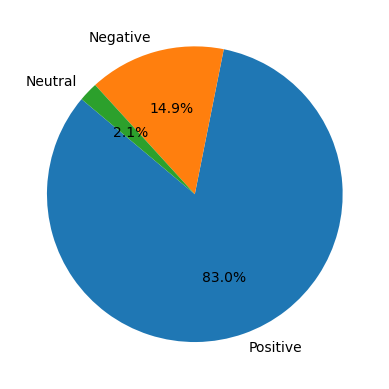

In [163]:
df1["rating_sentiment"] = df1["rating"].apply(ratings)
plt.pie(df1["rating_sentiment"].value_counts(), labels = df1["rating_sentiment"].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.show()

In [164]:
lenght = len(df1["review_text"][5])
print(f'Length of a sample review: {lenght}')

Length of a sample review: 114


### 2.2 Most occurning words

In [165]:
df1["Length"] = df1["review_text"].str.len()
df1.head()

,author,rating,review_text,date,rating_sentiment,Length
0,alish khabiyev,5,,2025-04-12,Positive,0
1,radmir asimzhanov,5,админ акрам отлично помог,2025-04-13,Positive,26
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13,Positive,274
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13,Positive,87
4,raushan uaisova,5,очень нравится именно филиал шефрана вкусная е...,2025-04-13,Positive,272


In [166]:
def word_count(review):
    review = review.split()
    return len(review)


In [167]:
df1["Word_Count"] = df1["review_text"].apply(word_count)
df1.head()

,author,rating,review_text,date,rating_sentiment,Length,Word_Count
0,alish khabiyev,5,,2025-04-12,Positive,0,0
1,radmir asimzhanov,5,админ акрам отлично помог,2025-04-13,Positive,26,4
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13,Positive,274,30
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13,Positive,87,11
4,raushan uaisova,5,очень нравится именно филиал шефрана вкусная е...,2025-04-13,Positive,272,31


In [168]:
def corpus(text):
    text_list = text.split()
    return text_list

In [169]:
df1['review_list'] = df1['review_text'].apply(corpus)
df1.head(10)

,author,rating,review_text,date,rating_sentiment,Length,Word_Count,review_list
0,alish khabiyev,5,,2025-04-12,Positive,0,0,[]
1,radmir asimzhanov,5,админ акрам отлично помог,2025-04-13,Positive,26,4,"[админ, акрам, отлично, помог]"
2,балжан мелс,5,хочу выразить благодарность замечательной офиц...,2025-04-13,Positive,274,30,"[хочу, выразить, благодарность, замечательной,..."
3,анара сейдалиева,5,бизге барлыгы унады ыстык тамактары корсеткен ...,2025-04-13,Positive,87,11,"[бизге, барлыгы, унады, ыстык, тамактары, корс..."
4,raushan uaisova,5,очень нравится именно филиал шефрана вкусная е...,2025-04-13,Positive,272,31,"[очень, нравится, именно, филиал, шефрана, вку..."
5,айман куанышева,5,стильный ремонт приятная обстановка приветливы...,2025-04-13,Positive,114,14,"[стильный, ремонт, приятная, обстановка, приве..."
6,дидар ырыстай,5,посетил shafran остался большим впечатлением и...,2025-04-13,Positive,476,56,"[посетил, shafran, остался, большим, впечатлен..."
7,диасс диасссс,5,акжолспасибо хорошое обслужваниеочень вкусные ...,2025-04-13,Positive,102,11,"[акжолспасибо, хорошое, обслужваниеочень, вкус..."
8,ербатыр топский,5,вкусно сытно хорошее обслуживание спасибо офиц...,2025-04-13,Positive,57,7,"[вкусно, сытно, хорошее, обслуживание, спасибо..."
9,асылхан садуакасов,5,бүгін отбасымызбен осы мейрамханадан кешкі асы...,2025-04-11,Positive,240,32,"[бүгін, отбасымызбен, осы, мейрамханадан, кешк..."


In [170]:
corpus = []
for i in trange(df1.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df1['review_list'][i]
len(corpus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [00:00<00:00, 81653.90it/s]


25088

In [171]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('очень', 791),
 ('обслуживание', 447),
 ('вкусно', 406),
 ('спасибо', 361),
 ('өте', 261),
 ('рахмет', 198),
 ('еда', 184),
 ('официант', 181),
 ('вкусная', 178),
 ('дәмді', 150)]

In [173]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

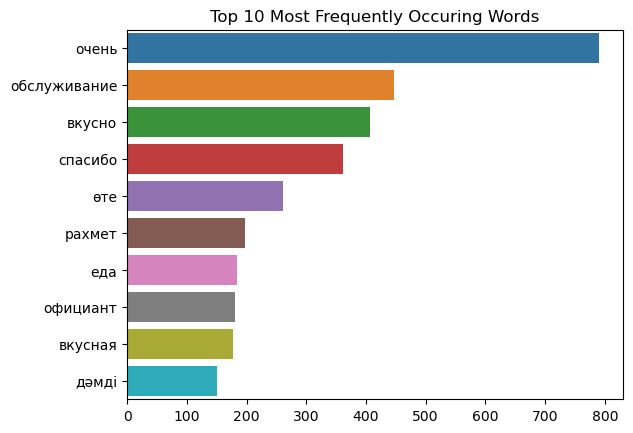

In [174]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

### Most Frequently occuring Bigrams


In [175]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(df1['review_text'])

In [177]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]


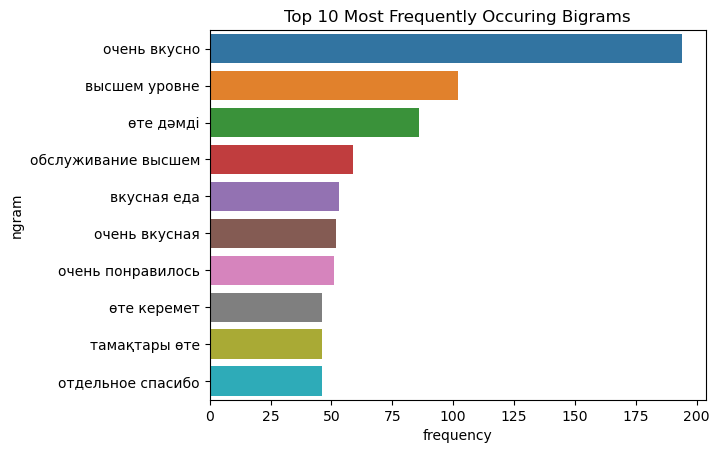

In [178]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

### Most Frequently occuring Trigrams


In [179]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df1['review_text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

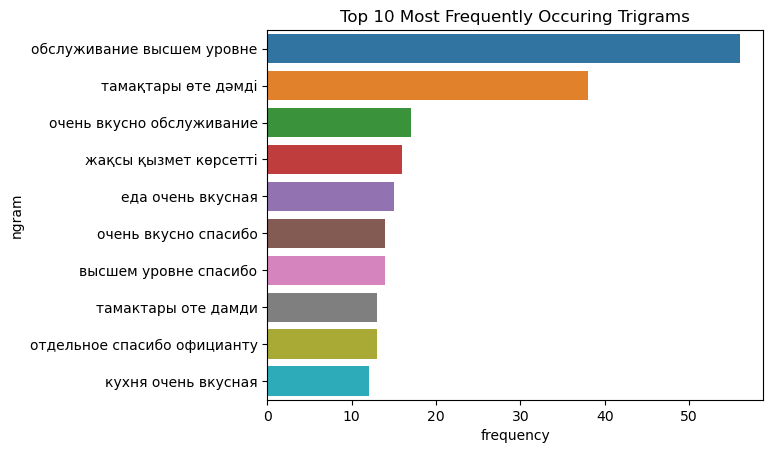

In [180]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

### Most common words for negative

In [186]:
negative_df = df1[df1['rating_sentiment'] == 'Negative']
print(negative_df.shape)
negative_df.head()

(261, 8)


,author,rating,review_text,date,rating_sentiment,Length,Word_Count,review_list
10,iii iii,1,принесли плов холодным тому запах странный — и...,2025-04-13,Negative,76,11,"[принесли, плов, холодным, тому, запах, странн..."
44,алма кусаинова,2,очень уютно красиво внутри лагман вкусный мясо...,2025-04-09,Negative,78,12,"[очень, уютно, красиво, внутри, лагман, вкусны..."
55,zhaiyk seitkalyk,1,обслуживание өте төмен сағат 1800 ге броньдап ...,2025-04-06,Negative,501,74,"[обслуживание, өте, төмен, сағат, 1800, ге, бр..."
80,бахыт касымкызы,2,парковки,2025-04-13,Negative,8,1,[парковки]
105,ali kad,1,өмірі телефон көтермейді,2025-03-29,Negative,24,3,"[өмірі, телефон, көтермейді]"


In [188]:
neg_corpus = []
for i in trange(negative_df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    neg_corpus += negative_df['review_list'].iloc[i]
len(neg_corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 93079.95it/s]


5632

In [189]:
mostCommon = Counter(neg_corpus).most_common(10)
mostCommon

[('обслуживание', 57),
 ('очень', 56),
 ('принесли', 50),
 ('это', 40),
 ('заказ', 39),
 ('минут', 34),
 ('лагман', 33),
 ('официанты', 31),
 ('ждали', 30),
 ('заказали', 30)]

### Most freq negative bigrams

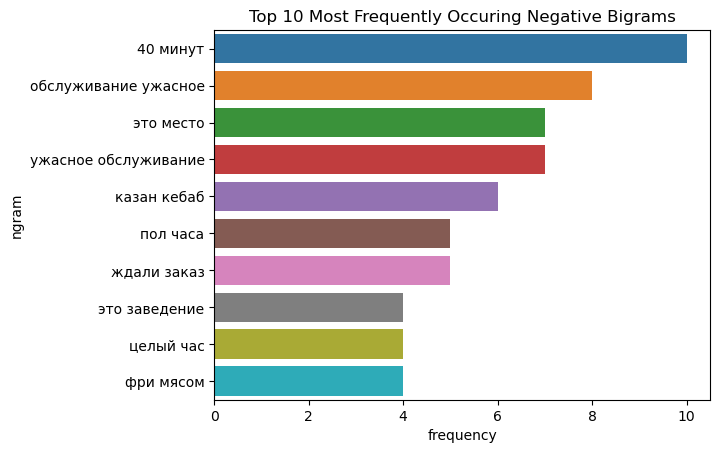

In [190]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(negative_df['review_text'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Negative Bigrams')
plt.show()


### Most freq negative trigrams

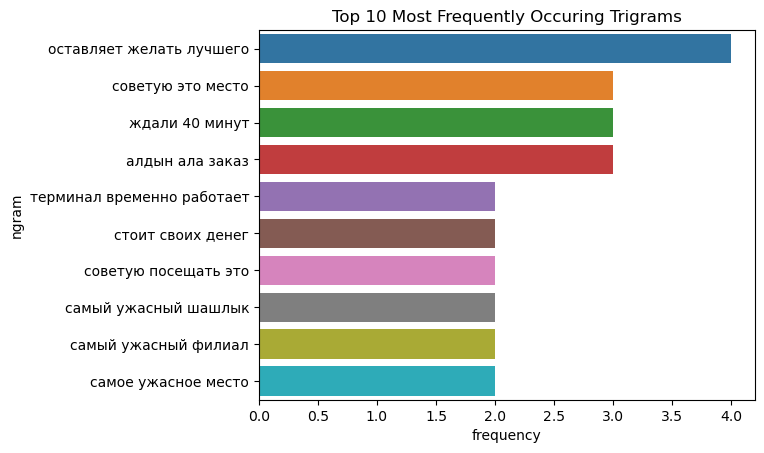

In [191]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(negative_df['review_text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()